In [1]:
'''
This script is used to genereate lineshape file from laser data for the DGA_simulator.
'''

%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sys
import pandas as pd
import os

sys.path.append(r'C:\Data\Python\Characterisation_Report_scripts\src\analysis')
import functions
import overview_tuning

plt.style.use(r"C:\Data\Python\Characterisation_Report_scripts\src\beamer_style.mplstyle")

In [2]:
class lineshapes():
    '''
    This class generates lineshape files from laser data. 
    example use:
    lineshapes(input file_path, ouput file_path)
    '''
    def __init__(self,overview_instance_file,output_file):
        '''
        loads data, generates linehsapes and saves it a pickle file. 
        @param overview_instance_file: path to the laser data file.
        @param output_file: file path to the ouput file. 
        '''
        self.get_lineshapes(overview_instance_file)
        self.smooth_lineshapes(5,3)
        self.save_lineshapes(output_file)
    
    def get_lineshapes(self,file_name):
        '''
        loads data an generates a Dataframe with the lineshapes. 
        Each column in the Dataframe corresponds the the lineshape of a particular wavelength (given by the column name)
        
        @param file_name: Path of the input file. 
        '''
        overview_instance=overview_tuning.overview_tuning(file_name,measurement_index=-1)
        measurement=overview_instance.data.measurement_dict_list[-1]
        wavelength_range=measurement[0]["D2"].ptp()
        wavelength_axis=np.linspace(-wavelength_range/2,wavelength_range/2,measurement[0]["D2"].shape[0])
        lineshapes_df=pd.DataFrame({'wavelength':wavelength_axis})
        for key, value in measurement.iteritems():
            if np.isnan(overview_instance.max_Wavelength_fitted[key]): # skip lineshaps with a nan wavelength
                continue
            ylist=value["intensities"]
            xlist=value['D2']-overview_instance.max_Wavelength_fitted[key] #shift to zero
            ylist=ylist/overview_instance.max_Power[key] #normalisation
            iterpol_lineshape=np.interp(wavelength_axis,xlist,ylist)
            lineshapes_df[str(overview_instance.max_Wavelength_fitted[key])]=iterpol_lineshape
            
        #sort lineshapes by wavelength
        sort_indexes=np.argsort(overview_instance.max_Wavelength_fitted[~np.isnan(overview_instance.max_Wavelength_fitted)])
        sorted_columns=lineshapes_df.columns[1:][sort_indexes]
        self.lineshapes_df=pd.DataFrame(lineshapes_df['wavelength'])
        for column in sorted_columns:
            self.lineshapes_df[column]=lineshapes_df[column]

    def smooth_lineshapes(self,window_size, order):
        '''
        smooths lineshapes with a savitzky_golay filter.
        
        @param window_size: the length of the window. Must be an odd integer number.
        @type window_size: int
        @param order: the order of the polynomial used in the filtering.
                        Must be less then `window_size` - 1
        @type order: int
        '''
        for column in self.lineshapes_df.columns[1:]:
            self.lineshapes_df[column]=functions.savitzky_golay(self.lineshapes_df[column].values,window_size,order)
            
    def save_lineshapes(self,file_name):
        '''
        saves the lineshape as a pandas Dataframe pickle.
        @param file_name: path to the ouput file
        '''
        self.lineshapes_df.to_pickle(file_name)
    
    def plot_lineshapes(self):
        '''
        plots the lineshapes.
        '''
        fig, ax=plt.subplots(1)
        for column in self.lineshapes_df.columns[1:]:
            ax.plot(self.lineshapes_df['wavelength'],self.lineshapes_df[column])
        plt.show()
        

In [3]:
#ls=lineshapes(r"C:\Data\Results\Auto_measurements\PN-12-024-SN0001\DGA_lineshape.txt",r"C:\Data\Python\DGA_simulator\sample_laser_files\PN-12-024-SN0001_lineshape.pck")
ls=lineshapes(r"C:\Data\Results\Auto_measurements\PN-12-028-SN0004\overview_tuning.txt",r"C:\Data\Python\DGA_simulator\sample_laser_files\PN-12-028-SN0004_lineshape.pck")

C:\Data\Python\Characterisation_Report_scripts\src\analysis\overview_tuning.py:495: RuntimeWarning: invalid value encountered in greater
  mode_hop_positions=np.ravel(np.argwhere(np.abs(diff)>50))


<IPython.core.display.Javascript object>


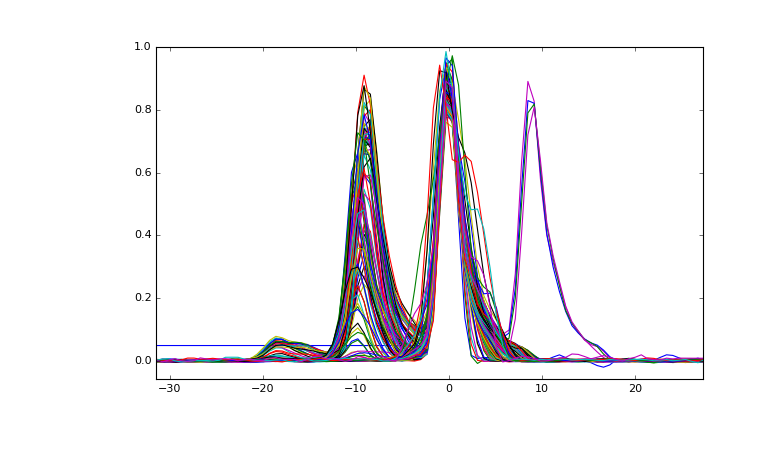

c:\python27\lib\site-packages\pandas\core\computation\check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [4]:
ls.plot_lineshapes()